# **Imports and Downloads**

In [2]:
#!pip install mlxtend==0.19.0 -q
#!pip install torch
#!pip install torchvision

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
%matplotlib inline

In [4]:
# set up the necessary data loaders and specify the input and output sizes to be used 
# when defining and training a machine learning model on the MNIST dataset.

device = torch.device('cuda')

batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset, 
                                batch_size=batch_size, 
                                shuffle=False)

input_size = 28*28
output_size =  10

100%|██████████| 9912422/9912422 [00:00<00:00, 325260017.71it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41244703.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 93468096.51it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 24518055.04it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## **generate_network_genotype**
"**1 - Defining a string-based representation for the networks (the genotype)**; **2 - Defining a string-based representation for the optimizer**; **3 - Sample all parameter values from a grammar (this allows for a restricted search space and removes the need to deal with invalid combinations).**"

**LinearNorm requires normalized_shape and BatchNorm1d require number of features, so they were added.**

The proposed genotype/ string structure is: 

"layer_type1|param1,param2;layer_type2|param1,...:activation_function-optimizer|param1,param2"

**Restrictions:**
The input size of a linear layer has to match the output size of the privious linear layer;
In BatchNorm1d the number of features has to match prev_out_features; normalized_shape in LayerNorm has to match the output size of the previous linear layer

In [5]:
def generate_network_genotype():
    '''
    This function generates a random network genotype for a neural network model.
    The genotype consists of layer configurations, activation function, and optimizer.
    It randomly determines the number of layers, layer types, and their parameters.
    The first and last layers are fixed to meet size requirements.
    The genotype is represented as a string and returned as the result.
    '''

    # Generate a random network genotype
    num_layers = random.randint(1, 48)  
    # Initialize the genotype list to store layer configurations
    genotype = [] 

    # Add the first linear layer
    in_features = 28 * 28  
    out_features = random.randint(10, 100)  
    bias = random.choice([True, False]) 
    genotype.append(f'Linear|{in_features},{out_features},{bias}')  
    prev_out_features = out_features 

    # Generate random layers
    for _ in range(num_layers - 1): 

        # Randomly choose a layer type from the available options
        layer_type = random.choice(['Linear','BatchNorm1d', 'LayerNorm', 'Dropout', 'AlphaDropout'])

        if layer_type == 'BatchNorm1d':
            num_features = prev_out_features  
            eps = random.uniform(1e-5, 1e-3)
            momentum = random.uniform(0.1, 0.9)
            genotype.append(f'{layer_type}|{num_features},{eps},{momentum}')
        elif layer_type == 'LayerNorm':
            normalized_shape = prev_out_features  
            eps = random.uniform(1e-5, 1e-3)
            genotype.append(f'{layer_type}|{normalized_shape},{eps}')
        elif layer_type in ['Dropout', 'AlphaDropout']:
            p = random.uniform(0.1, 0.5)
            genotype.append(f'{layer_type}|{p}')
        elif layer_type == 'Linear':
            out_features = random.randint(10, 100)
            bias = random.choice([True, False])
            genotype.append(f'Linear|{prev_out_features},{out_features},{bias}')
            prev_out_features = out_features 

    # Add the last linear layer with output size of 10
    genotype.append(f'Linear|{prev_out_features},10,True')

    # Generate random activation function
    activation_function = random.choice(['Sigmoid', 'ReLU', 'PReLU', 'ELU', 'SELU', 'GELU', 'CELU', 'SiLU'])
    
    # Generate random optimizer
    optimizer = random.choice(['Adam', 'AdamW', 'Adadelta', 'NAdam', 'SGD'])
    optimizer_params = []

    if optimizer in ['Adam', 'AdamW']:
        lr = random.uniform(0.001, 0.01)
        beta1 = random.uniform(0.9, 0.99)
        beta2 = random.uniform(0.9, 0.99)
        optimizer_params.extend([lr, beta1, beta2])
        if optimizer == 'AdamW':
            weight_decay = random.uniform(0.01, 0.1)
            optimizer_params.append(weight_decay)
    elif optimizer == 'Adadelta':
        lr = random.uniform(0.1, 1.0)
        rho = random.uniform(0.8, 0.99)
        optimizer_params.extend([lr, rho])
    elif optimizer == 'NAdam':
        lr = random.uniform(0.001, 0.01)
        beta1 = random.uniform(0.9, 0.99)
        beta2 = random.uniform(0.9, 0.99)
        momentum_decay = random.uniform(0.1, 0.99)
        optimizer_params.extend([lr, beta1, beta2, momentum_decay])
    elif optimizer == 'SGD':
        lr = random.uniform(0.01, 0.1)
        momentum = random.uniform(0.1, 0.9)
        nesterov = random.choice([True, False])
        optimizer_params.extend([lr, momentum, nesterov])

    # Combine layers, activation function, and optimizer
    genotype_str = ';'.join(genotype)
    optimizer_params_str = ','.join(map(str, optimizer_params)) 
    genotype_str += f':{activation_function}-{optimizer}|{optimizer_params_str}'

    # Return the genotype
    return genotype_str

# Example usage
genotype = generate_network_genotype()
layer_list = [genotype]
print(layer_list)


['Linear|784,12,True;Dropout|0.29032337924276;AlphaDropout|0.2804940953875098;Dropout|0.2647508002049708;AlphaDropout|0.4034195373697591;AlphaDropout|0.41698919493468145;Dropout|0.29103644511723514;AlphaDropout|0.4596130332589521;Dropout|0.3701747693039268;Dropout|0.22066456901002807;AlphaDropout|0.49281487654806955;LayerNorm|12,0.0009229938083296842;Dropout|0.37506819590739926;AlphaDropout|0.43080157747329584;Linear|12,10,True:CELU-NAdam|0.0018166960486315784,0.9128151321861289,0.9277111398395071,0.3446792009507872']


# **Net class**
"**1 -Defining a network class that is able to parse those instructions and build a functional pytorch network structure (the phenotype).**; **2 - Defining a way to parse those instructions and build and functional pytorch optimizer.**"

In [7]:
class Net(nn.Module):
    '''
      This class creates a neural network model with customizable layer configurations.
    '''

    def __init__(self, layer_list):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.activation_function = None
        self.optimizer = None

        # Parse layers, activation function, and optimizer
        for layer_str in layer_list:
            self.parse_layers(layer_str)
            self.parse_activation_optimizer(layer_str)

        # To flatten the images into 1D arrays
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.flat(x)
        for layer in self.layers:
            x = layer(x)
        return x

    def parse_layers(self, layer_str):
        # Split the layer string into individual layer strings
        layers_str = layer_str.split(':')[0].split(';')
        for layer in layers_str:
            # Parse and append each layer to the layers list
            self.layers.append(self.parse_layer_string(layer))

    def parse_activation_optimizer(self, activation_optimizer_str):
        # Split the activation and optimizer string        
        activation_optimizer_parts = activation_optimizer_str.split(':')[-1].split('-')
        # Parse activation function
        self.parse_activation_function(activation_optimizer_parts[0])
        # Parse optimizer
        self.parse_optimizer(activation_optimizer_parts[1])



    def parse_layer_string(self, layer_str):
        # Split the layer string into type and parameters
        layer_parts = layer_str.split('|')
        layer_type = layer_parts[0]
        layer_params = layer_parts[1].split(',')

        if layer_type == 'Linear':
            in_features = int(layer_params[0])
            out_features = int(layer_params[1])
            bias = bool(layer_params[2])
            return nn.Linear(in_features, out_features, bias)
        elif layer_type == 'BatchNorm1d':       
            features = int(layer_params[0])
            eps = float(layer_params[1])
            momentum = float(layer_params[2])
            return nn.BatchNorm1d(num_features=features, eps=eps, momentum=momentum)
        elif layer_type == 'LayerNorm':
            normalized_shape = int(layer_params[0])
            eps = float(layer_params[1])
            return nn.LayerNorm(normalized_shape, eps=eps)
        elif layer_type == 'Dropout':
            p = float(layer_params[0])
            return nn.Dropout(p=p)
        elif layer_type == 'AlphaDropout':
            p = float(layer_params[0])
            return nn.AlphaDropout(p=p)
        else:
            raise ValueError('Invalid layer string: {}'.format(layer_str))

    def parse_activation_function(self, activation_function_str):
        if activation_function_str == 'Sigmoid':
            self.activation_function = nn.Sigmoid()
        elif activation_function_str == 'ReLU':
            self.activation_function = nn.ReLU()
        elif activation_function_str == 'PReLU':
            self.activation_function = nn.PReLU()
        elif activation_function_str == 'ELU':
            self.activation_function = nn.ELU()
        elif activation_function_str == 'SELU':
            self.activation_function = nn.SELU()
        elif activation_function_str == 'GELU':
            self.activation_function = nn.GELU()
        elif activation_function_str == 'CELU':
            self.activation_function = nn.CELU()
        elif activation_function_str == 'SiLU':
            self.activation_function = nn.SiLU()
        else:
            raise ValueError('Invalid activation function: {}'.format(activation_function_str))

    def parse_optimizer(self, optimizer_str):
        optimizer_parts = optimizer_str.split('|')
        optimizer_name = optimizer_parts[0]
        optimizer_params = optimizer_parts[1].split(',')

        if optimizer_name == 'Adam':
            lr = float(optimizer_params[0])
            betas = (float(optimizer_params[1]), float(optimizer_params[2]))
            self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, betas=betas)
        elif optimizer_name == 'AdamW':
            lr = float(optimizer_params[0])
            betas = (float(optimizer_params[1]), float(optimizer_params[2]))
            weight_decay = float(optimizer_params[3])
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        elif optimizer_name == 'Adadelta':
            lr = float(optimizer_params[0])
            rho = float(optimizer_params[1])
            self.optimizer = torch.optim.Adadelta(self.parameters(), lr=lr, rho=rho)
        elif optimizer_name == 'NAdam':
            lr = float(optimizer_params[0])
            betas = (float(optimizer_params[1]), float(optimizer_params[2]))
            momentum_decay = float(optimizer_params[3])
            self.optimizer = torch.optim.NAdam(self.parameters(), lr=lr, betas=betas, momentum_decay=momentum_decay)
        elif optimizer_name == 'SGD':
            lr = float(optimizer_params[0])
            momentum = float(optimizer_params[1])
            nesterov = bool(optimizer_params[2])
            self.optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
        else:
            raise ValueError('Invalid optimizer: {}'.format(optimizer_name))

# Example usage
net = Net(layer_list)
print(net)


Net(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=12, bias=True)
    (1): Dropout(p=0.29032337924276, inplace=False)
    (2): AlphaDropout(p=0.2804940953875098, inplace=False)
    (3): Dropout(p=0.2647508002049708, inplace=False)
    (4): AlphaDropout(p=0.4034195373697591, inplace=False)
    (5): AlphaDropout(p=0.41698919493468145, inplace=False)
    (6): Dropout(p=0.29103644511723514, inplace=False)
    (7): AlphaDropout(p=0.4596130332589521, inplace=False)
    (8): Dropout(p=0.3701747693039268, inplace=False)
    (9): Dropout(p=0.22066456901002807, inplace=False)
    (10): AlphaDropout(p=0.49281487654806955, inplace=False)
    (11): LayerNorm((12,), eps=0.0009229938083296842, elementwise_affine=True)
    (12): Dropout(p=0.37506819590739926, inplace=False)
    (13): AlphaDropout(p=0.43080157747329584, inplace=False)
    (14): Linear(in_features=12, out_features=10, bias=True)
  )
  (activation_function): CELU(alpha=1.0)
  (flat): Flatten(start_dim=1, end_dim=-

# **Generate 5 random networks,save them, and train them.**
**The networks will be trained on the MNIST dataset, for 50 epochs, following the same procedure as used in the practical classes (showing the training and validation loss and accuracy per epoch).**

In [8]:
# Initialize lists to store genotypes, losses and accuracies
network_genotypes = []
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

def training(num_networks,num_epochs):

  for i in range(num_networks):
      print(f'Training Network {i+1}')
      # Generate random network genotype
      genotype = generate_network_genotype()
      network_genotypes.append(genotype)
      layer_list = [genotype]

      # Create the network
      model = Net(layer_list).to(device)

      # Define the loss function and optimizer
      loss_fn = nn.CrossEntropyLoss()
      optimizer = model.optimizer

      # Lists to store training and validation losses and accuracies
      train_loss = []
      validation_loss = []
      train_accuracy = []
      validation_accuracy = []

      # Training loop
      for epoch in range(num_epochs):
          model.train()
          total_loss_train = 0
          correct_train = 0
          total_train = 0

          for x_batch, y_batch in train_loader:
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)

              optimizer.zero_grad()
              outputs = model(x_batch)
              loss = loss_fn(outputs, y_batch)
              loss.backward()
              optimizer.step()

              total_loss_train += loss.item()
              _, predicted_train = torch.max(outputs.data, 1)
              total_train += y_batch.size(0)
              correct_train += (predicted_train == y_batch).sum().item()

          accuracy_train = 100 * correct_train / total_train
          avg_loss_train = total_loss_train / len(train_loader)

          # Store training loss and accuracy
          train_loss.append(avg_loss_train)
          train_accuracy.append(accuracy_train)

          model.eval()
          total_loss_val = 0
          correct_val = 0
          total_val = 0

          with torch.no_grad():
              for x_batch, y_batch in validation_loader:
                  x_batch = x_batch.to(device)
                  y_batch = y_batch.to(device)

                  outputs = model(x_batch)
                  loss = loss_fn(outputs, y_batch)

                  total_loss_val += loss.item()
                  _, predicted_val = torch.max(outputs.data, 1)
                  total_val += y_batch.size(0)
                  correct_val += (predicted_val == y_batch).sum().item()

          accuracy_val = 100 * correct_val / total_val
          avg_loss_val = total_loss_val / len(validation_loader)

          # Store validation loss and accuracy
          validation_loss.append(avg_loss_val)
          validation_accuracy.append(accuracy_val)

          print(f'Network {i+1}  Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss_train:.4f}  Accuracy: {accuracy_train:.2f}%  Validation Loss: {avg_loss_val:.4f}  Validation Accuracy: {accuracy_val:.2f}%')

      # Save the model after training
      torch.save(model.state_dict(), f'network_{i+1}.pt')

      # Append the losses and accuracies to the main lists
      train_losses.append(train_loss)
      validation_losses.append(validation_loss)
      train_accuracies.append(train_accuracy)
      validation_accuracies.append(validation_accuracy)

  return train_losses, validation_losses, train_accuracies, validation_accuracies

# Train the networks
num_networks = 5
num_epochs = 50

train_losses, validation_losses, train_accuracies, validation_accuracies = training(num_networks,num_epochs)


Training Network 1
Network 1  Epoch [1/50]  Loss: 1.7408  Accuracy: 31.42%  Validation Loss: 1.2090  Validation Accuracy: 60.24%
Network 1  Epoch [2/50]  Loss: 1.3638  Accuracy: 48.59%  Validation Loss: 0.8056  Validation Accuracy: 73.41%
Network 1  Epoch [3/50]  Loss: 1.2279  Accuracy: 54.86%  Validation Loss: 0.9158  Validation Accuracy: 74.81%
Network 1  Epoch [4/50]  Loss: 1.1906  Accuracy: 56.39%  Validation Loss: 0.7253  Validation Accuracy: 74.88%
Network 1  Epoch [5/50]  Loss: 1.1734  Accuracy: 57.17%  Validation Loss: 1.0850  Validation Accuracy: 72.29%
Network 1  Epoch [6/50]  Loss: 1.1785  Accuracy: 56.53%  Validation Loss: 0.6944  Validation Accuracy: 77.09%
Network 1  Epoch [7/50]  Loss: 1.1773  Accuracy: 56.80%  Validation Loss: 0.7713  Validation Accuracy: 72.05%
Network 1  Epoch [8/50]  Loss: 1.1675  Accuracy: 56.94%  Validation Loss: 0.7100  Validation Accuracy: 73.71%
Network 1  Epoch [9/50]  Loss: 1.1659  Accuracy: 57.20%  Validation Loss: 0.7199  Validation Accuracy

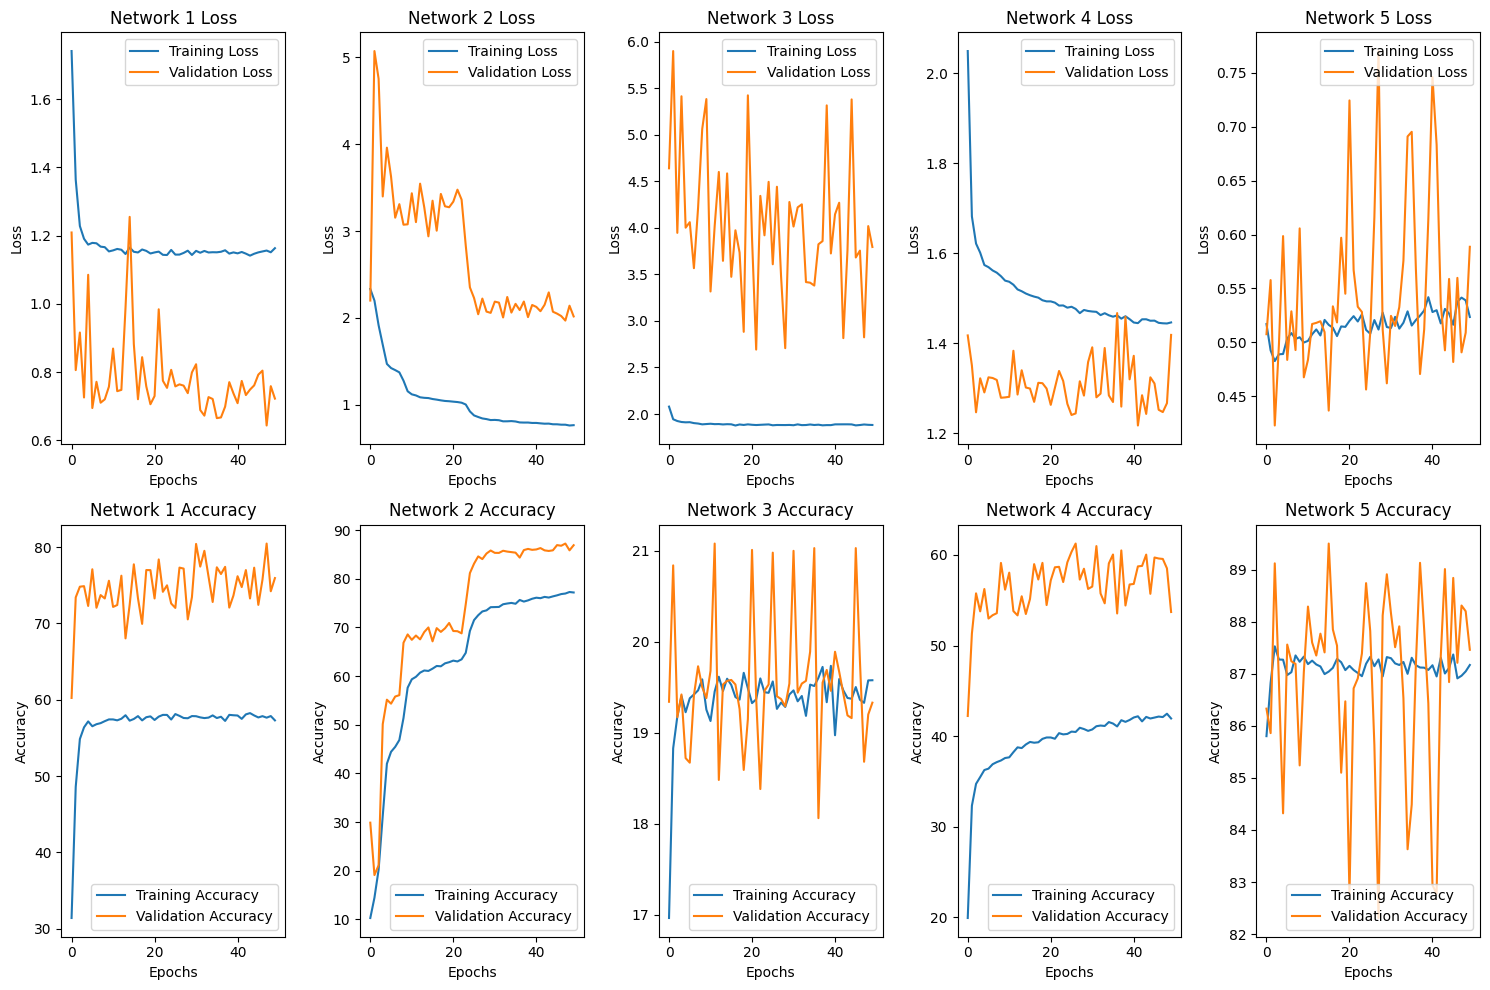

In [9]:
fig, axs = plt.subplots(2, num_networks, figsize=(15, 10))

for i in range(num_networks):
    # Plotting training and validation loss
    axs[0, i].plot(range(num_epochs), train_losses[i], label='Training Loss')
    axs[0, i].plot(range(num_epochs), validation_losses[i], label='Validation Loss')
    axs[0, i].set_title(f'Network {i+1} Loss')
    axs[0, i].set_xlabel('Epochs')
    axs[0, i].set_ylabel('Loss')
    axs[0, i].legend(loc="upper right")

    # Plotting training and validation accuracy
    axs[1, i].plot(range(num_epochs), train_accuracies[i], label='Training Accuracy')
    axs[1, i].plot(range(num_epochs), validation_accuracies[i], label='Validation Accuracy')
    axs[1, i].set_title(f'Network {i+1} Accuracy')
    axs[1, i].set_xlabel('Epochs')
    axs[1, i].set_ylabel('Accuracy')
    axs[1, i].legend(loc="lower right")

plt.tight_layout()
plt.show()


### **Operators**

*   Change_optimizer_mutation - There is a 50% chance that the optimizer type will change. If the optimizer changes a new set of parameters is selected, and if the optimizer remains the same a new set of parameters is selected.

*   Remove_layer_mutation - checks if the length of the total layers in the network is greater than 2. Otherwise, the code would delete either the input or output layer. A linear layer cannot be deleted as it would cause mismatches in the shapes of the network.

*   Add_layer_mutation - The Add Layer function adds a new layer to the network genotype, if the model has less than 50 layers. The only layers allowed to be added are Dropout and AlphaDropout since the others input sizes are dependent on the ouput size of the privous linear layer. 

*   Crossover - This function performs crossover between two network genotypes by randomly selecting a subset from each genotype - only subsets that don't contain the fisrt layer, the last layer, or 'Linear', 'BatchNorm1d', and 'LayerNorm' layers are swapped- the subsets are found through the function find_consecutive_subsets().


In [10]:
# Optimizer mutation options
optimizer_types = ['Adam', 'AdamW', 'Adadelta', 'NAdam', 'SGD']
lr_range = (1e-5, 1e-1)  # Learning rate range
momentum_range = (0, 1)  # Momentum range
betas_range = (0.5, 0.999)  # Betas range
weight_decay_range = (0, 0.1)  # Weight decay range
rho_range = (0, 1)  # rho range for Adadelta
momentum_decay_range = (0, 1)  # momentum decay range for NAdam

def change_optimizer_mutation(network_genotype):
    # Parse existing optimizer
    optimizer_parts = network_genotype.split(':')[-1].split('-')
    optimizer_str = optimizer_parts[1]
    optimizer_name, optimizer_params_str = optimizer_str.split('|')
    optimizer_params = optimizer_params_str.split(',')

    # Randomly choose whether to change optimizer type or its parameters
    if random.random() < 0.5:  # Change optimizer type
        new_optimizer_name = random.choice(optimizer_types)
    else:  # Change optimizer parameters
        new_optimizer_name = optimizer_name

    # Randomly choose new parameters based on the new optimizer type
    if new_optimizer_name in ['Adam', 'AdamW', 'NAdam']:
        lr = random.uniform(*lr_range)
        betas = (random.uniform(*betas_range), random.uniform(*betas_range))
        new_optimizer_params = [lr, *betas]
        if new_optimizer_name == 'AdamW':
            weight_decay = random.uniform(*weight_decay_range)
            new_optimizer_params.append(weight_decay)
        if new_optimizer_name == 'NAdam':
            momentum_decay = random.uniform(*momentum_decay_range)
            new_optimizer_params.append(momentum_decay)
    elif new_optimizer_name == 'Adadelta':
        lr = random.uniform(*lr_range)
        rho = random.uniform(*rho_range)
        new_optimizer_params = [lr, rho]
    elif new_optimizer_name == 'SGD':
        lr = random.uniform(*lr_range)
        momentum = random.uniform(*momentum_range)
        nesterov = random.choice([True, False])
        new_optimizer_params = [lr, momentum, nesterov]

    # Replace optimizer in genotype
    new_optimizer_str = new_optimizer_name + '|' + ','.join(map(str, new_optimizer_params))
    new_network_genotype = network_genotype.replace(optimizer_str, new_optimizer_str)

    return new_network_genotype


def remove_layer_mutation(network_genotype):
    # Split the genotype into layer strings and optimizer string
    layer_strs, optimizer_str = network_genotype.split(":")
    layers = layer_strs.split(";")

    # Make sure there are at least 2 layers 
    if len(layers) < 3:
        return network_genotype

    # Select a random index of a non-linear layer to remove (not first or last)
    layer_indices_to_remove = [i for i in range(1, len(layers)-1) if not layers[i].startswith('Linear')]
    if not layer_indices_to_remove:
        return network_genotype  # No non-linear layer to remove
    index_to_remove = random.choice(layer_indices_to_remove)

    # Remove the layer
    del layers[index_to_remove]

    # Reconstruct the network genotype
    new_network_genotype = ';'.join(layers) + ':' + optimizer_str
    return new_network_genotype

def add_layer_mutation(network_genotype):
    # Define layer types and parameters
    layer_types = ['Dropout', 'AlphaDropout']
    dropout_p_range = (0.1, 0.5)

    # Split the genotype into layer strings and optimizer string
    layer_strs, optimizer_str = network_genotype.split(":")
    layers = layer_strs.split(";")

    # Make sure there are less than 50 layers (input, 48 hidden layers, output)
    if len(layers) >= 50:
        return network_genotype

    # Select a random index to insert a new layer (not before first or after last)
    index_to_insert = random.randint(1, len(layers) - 1)

    # Select a random layer type and generate parameters
    layer_type = random.choice(layer_types)
    if layer_type == 'Dropout':
        p = random.uniform(*dropout_p_range)
        new_layer_str = f'Dropout|{p}'
    elif layer_type == 'AlphaDropout':
        p = random.uniform(*dropout_p_range)
        new_layer_str = f'AlphaDropout|{p}'

    # Insert the new layer
    layers.insert(index_to_insert, new_layer_str)

    # Reconstruct the network genotype
    new_network_genotype = ';'.join(layers) + ':' + optimizer_str
    return new_network_genotype

def crossover(network_genotype_1, network_genotype_2):
    # Split the genotypes into layer strings and optimizer strings
    layers_1, optimizer_1 = network_genotype_1.split(":")
    layers_2, optimizer_2 = network_genotype_2.split(":")
    
    layers_1 = layers_1.split(";")
    layers_2 = layers_2.split(";")

    # Exclude first and last layers
    middle_layers_1 = layers_1[1:-1]
    middle_layers_2 = layers_2[1:-1]
    
    # Make sure both networks have at least three layers (input, hidden, output)
    if len(middle_layers_1) < 3 or len(middle_layers_2) < 3:
        return network_genotype_1, network_genotype_2

    # Identify all subsets of consecutive layers that do not include 'Linear', 'BatchNorm1d', or 'LayerNorm' layers
    subsets_1 = find_consecutive_subsets(middle_layers_1)
    subsets_2 = find_consecutive_subsets(middle_layers_2)

    # If no valid subset is found, return the original genotypes
    if len(subsets_1) == 0 or len(subsets_2) == 0:
        return network_genotype_1, network_genotype_2
    
    # Randomly select a subset from each genotype
    swap_subset_1 = random.choice(subsets_1)
    swap_subset_2 = random.choice(subsets_2)
    
    # Find the index range of each subset in the original layer list
    index_range_1 = (layers_1.index(swap_subset_1[0]), layers_1.index(swap_subset_1[-1]))
    index_range_2 = (layers_2.index(swap_subset_2[0]), layers_2.index(swap_subset_2[-1]))

    # Swap the subsets
    layers_1[index_range_1[0] : index_range_1[1]+1] = swap_subset_2
    layers_2[index_range_2[0] : index_range_2[1]+1] = swap_subset_1

    # Reconstruct the network genotypes
    new_network_genotype_1 = ';'.join(layers_1) + ':' + optimizer_1
    new_network_genotype_2 = ';'.join(layers_2) + ':' + optimizer_2
    
    return new_network_genotype_1, new_network_genotype_2


def find_consecutive_subsets(layer_list):
    """Find all subsets of consecutive layers that do not include 'Linear', 'BatchNorm1d', or 'LayerNorm' layers."""
    forbidden_layers = ('Linear', 'BatchNorm1d', 'LayerNorm')
    subsets = []
    subset = []

    for layer in layer_list:
        if layer.startswith(forbidden_layers):
            if len(subset) > 0:
                subsets.append(subset)
                subset = []
        else:
            subset.append(layer)

    # If there's still a subset left over, append it to subsets
    if len(subset) > 0:
        subsets.append(subset)
    
    return subsets


### **Experimental Setup**

*   Create 5 neural networks.
*   Apply crossover to two neural networks.
*   Apply each mutation to the remaining three networks.

In [11]:
new_network_genotypes=[]

# Remove function
new_layer_list = remove_layer_mutation(network_genotypes[0])
new_layer_list=[new_layer_list]
new_network_genotypes.append(new_layer_list)

# Add function
new_layer_list = add_layer_mutation(network_genotypes[1])
new_layer_list=[new_layer_list]
new_network_genotypes.append(new_layer_list)


# Optimizer mutation function
new_layer_list=change_optimizer_mutation(network_genotypes[2])
new_layer_list=[new_layer_list]
new_network_genotypes.append(new_layer_list)


# Crossover operation
new_genotype_1, new_genotype_2 = crossover(network_genotypes[3], network_genotypes[4])
new_genotype_1=[new_genotype_1]
new_genotype_2=[new_genotype_2]
new_network_genotypes.append(new_genotype_1)
new_network_genotypes.append(new_genotype_2)


### **Retraining the model**

In [12]:
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

def training_op(num_networks,num_epochs):
  for i in range(num_networks):
      print(f'Training Network {i+1}')

      # Get genotype from new_network_genotypes
      genotype = new_network_genotypes[i]

      # Create the network
      model = Net(genotype).to(device)

      # Define the loss function and optimizer
      loss_fn = nn.CrossEntropyLoss()
      optimizer = model.optimizer

      # Lists to store training and validation losses and accuracies
      train_losses_network = []
      validation_losses_network = []
      train_accuracies_network = []
      validation_accuracies_network = []

      # Training loop
      for epoch in range(num_epochs):
          model.train()
          total_loss_train = 0
          correct_train = 0
          total_train = 0

          for x_batch, y_batch in train_loader:
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)

              optimizer.zero_grad()
              outputs = model(x_batch)
              loss = loss_fn(outputs, y_batch)
              loss.backward()
              optimizer.step()

              total_loss_train += loss.item()
              _, predicted_train = torch.max(outputs.data, 1)
              total_train += y_batch.size(0)
              correct_train += (predicted_train == y_batch).sum().item()

          accuracy_train = 100 * correct_train / total_train
          avg_loss_train = total_loss_train / len(train_loader)

          # Store training loss and accuracy
          train_losses_network.append(avg_loss_train)
          train_accuracies_network.append(accuracy_train)

          model.eval()
          total_loss_val = 0
          correct_val = 0
          total_val = 0

          with torch.no_grad():
              for x_batch, y_batch in validation_loader:
                  x_batch = x_batch.to(device)
                  y_batch = y_batch.to(device)

                  outputs = model(x_batch)
                  loss = loss_fn(outputs, y_batch)

                  total_loss_val += loss.item()
                  _, predicted_val = torch.max(outputs.data, 1)
                  total_val += y_batch.size(0)
                  correct_val += (predicted_val == y_batch).sum().item()

          accuracy_val = 100 * correct_val / total_val
          avg_loss_val = total_loss_val / len(validation_loader)

          # Store validation loss and accuracy
          validation_losses_network.append(avg_loss_val)
          validation_accuracies_network.append(accuracy_val)

          print(f'Network {i+1}  Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss_train:.4f}  Accuracy: {accuracy_train:.2f}%  Validation Loss: {avg_loss_val:.4f}  Validation Accuracy: {accuracy_val:.2f}%')

      # Append the losses and accuracies to the main lists
      train_losses.append(train_losses_network)
      validation_losses.append(validation_losses_network)
      train_accuracies.append(train_accuracies_network)
      validation_accuracies.append(validation_accuracies_network)

  return train_losses, validation_losses, train_accuracies, validation_accuracies

# Train the networks
num_networks_op = len(new_network_genotypes)
num_epochs_op = 50

train_losses_op, validation_losses_op, train_accuracies_op, validation_accuracies_op = training_op(num_networks,num_epochs)


Training Network 1
Network 1  Epoch [1/50]  Loss: 1.2782  Accuracy: 55.00%  Validation Loss: 0.5411  Validation Accuracy: 84.54%
Network 1  Epoch [2/50]  Loss: 0.9607  Accuracy: 68.69%  Validation Loss: 0.4457  Validation Accuracy: 87.92%
Network 1  Epoch [3/50]  Loss: 0.9026  Accuracy: 71.17%  Validation Loss: 0.3733  Validation Accuracy: 89.90%
Network 1  Epoch [4/50]  Loss: 0.8589  Accuracy: 72.98%  Validation Loss: 0.3726  Validation Accuracy: 89.73%
Network 1  Epoch [5/50]  Loss: 0.8507  Accuracy: 73.52%  Validation Loss: 0.4055  Validation Accuracy: 89.18%
Network 1  Epoch [6/50]  Loss: 0.8397  Accuracy: 73.74%  Validation Loss: 0.5037  Validation Accuracy: 84.52%
Network 1  Epoch [7/50]  Loss: 0.8407  Accuracy: 73.84%  Validation Loss: 0.4359  Validation Accuracy: 87.36%
Network 1  Epoch [8/50]  Loss: 0.8349  Accuracy: 73.92%  Validation Loss: 0.3390  Validation Accuracy: 91.15%
Network 1  Epoch [9/50]  Loss: 0.8173  Accuracy: 74.70%  Validation Loss: 0.4340  Validation Accuracy

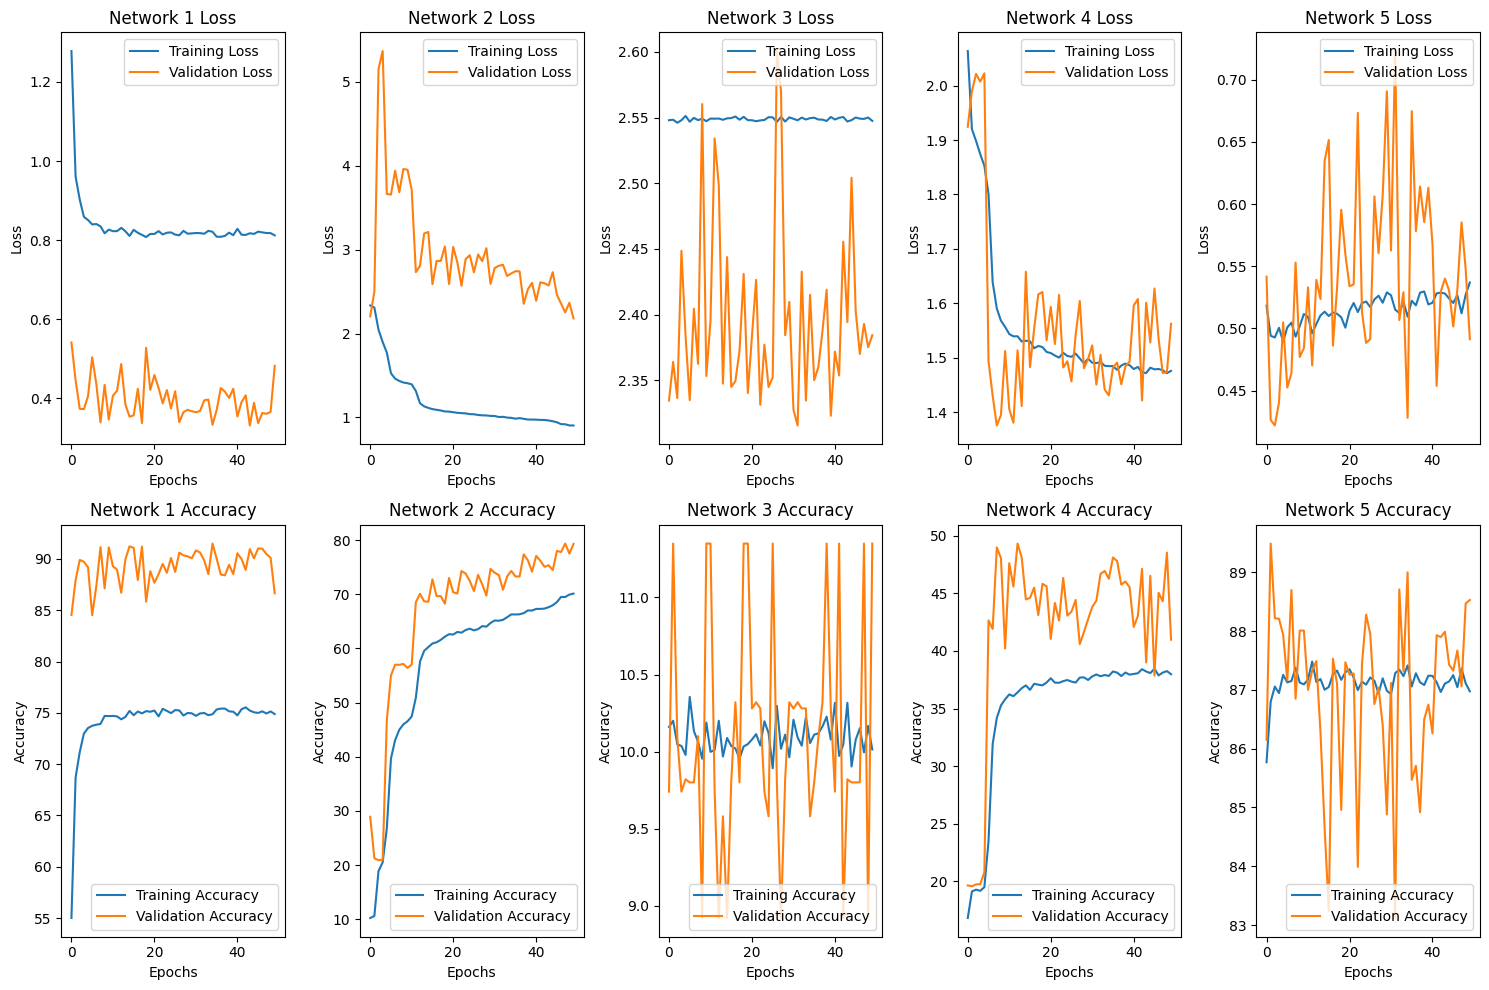

In [13]:
fig, axs = plt.subplots(2, num_networks_op, figsize=(15, 10))

for i in range(num_networks_op):
    # Plotting training and validation loss
    axs[0, i].plot(range(num_epochs_op), train_losses_op[i], label='Training Loss')
    axs[0, i].plot(range(num_epochs_op), validation_losses_op[i], label='Validation Loss')
    axs[0, i].set_title(f'Network {i+1} Loss')
    axs[0, i].set_xlabel('Epochs')
    axs[0, i].set_ylabel('Loss')
    axs[0, i].legend(loc="upper right")

    # Plotting training and validation accuracy
    axs[1, i].plot(range(num_epochs_op), train_accuracies_op[i], label='Training Accuracy')
    axs[1, i].plot(range(num_epochs_op), validation_accuracies_op[i], label='Validation Accuracy')
    axs[1, i].set_title(f'Network {i+1} Accuracy')
    axs[1, i].set_xlabel('Epochs')
    axs[1, i].set_ylabel('Accuracy')
    axs[1, i].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [16]:
# Here you can see the difference between the baseline model and the evolved model.
for i in range (5):
    print([network_genotypes[i]])
    print(new_network_genotypes[i])
    print("-------------------------")

['Linear|784,91,True;BatchNorm1d|91,0.0008670113415704919,0.26893101120117613;AlphaDropout|0.3273491085829896;LayerNorm|91,0.0006430591800123215;LayerNorm|91,0.00044803486082241334;LayerNorm|91,0.0003561363143418479;BatchNorm1d|91,0.0007957469439553291,0.8148206414993376;Dropout|0.16838140370972743;LayerNorm|91,0.0007910247087733751;Dropout|0.2512947769887055;LayerNorm|91,0.0007156381313357425;BatchNorm1d|91,0.0007989015187892963,0.3704750625220382;Linear|91,78,True;BatchNorm1d|78,0.00015220155367388807,0.3287440136648725;Dropout|0.19055772380306735;BatchNorm1d|78,0.0003850031207958644,0.733837459796791;AlphaDropout|0.48202937967626514;LayerNorm|78,0.0009218786436567432;AlphaDropout|0.13892033412231972;AlphaDropout|0.2609753945128886;AlphaDropout|0.2120649622835664;Dropout|0.26030576291263796;BatchNorm1d|78,0.0007756326860473535,0.7075334691494077;Linear|78,51,True;Linear|51,23,False;LayerNorm|23,0.0009771551285041834;LayerNorm|23,0.0006730591865238773;AlphaDropout|0.22535795470283235;